In [1]:
!pip install --user matplotlib==3.5

In [2]:
import os, sys, itertools, glob, torch, torchvision, cv2, natsort
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
from numpy import asarray
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
torch.manual_seed(46)
from torch import nn
import torchvision
from torchview import draw_graph
import torch.nn.functional as F
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution, NoiseTunnel, GuidedGradCam

In [3]:
print('Folders inside the main directory: ', os.listdir("C:/Users/aless/Desktop/gaf_imgs"))

Folders inside the main directory:  ['anxiety', 'baseline']


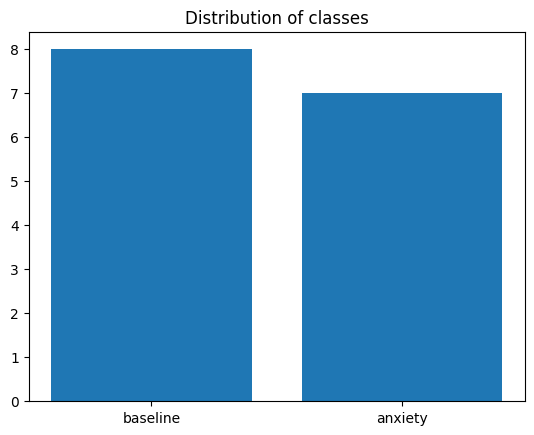

In [4]:
classes = ['baseline', 'anxiety']
sum_images = []
for i in classes:
    img_base_path = "C:/Users/aless/Desktop/gaf_imgs/" + str(i)
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes')
plt.show()

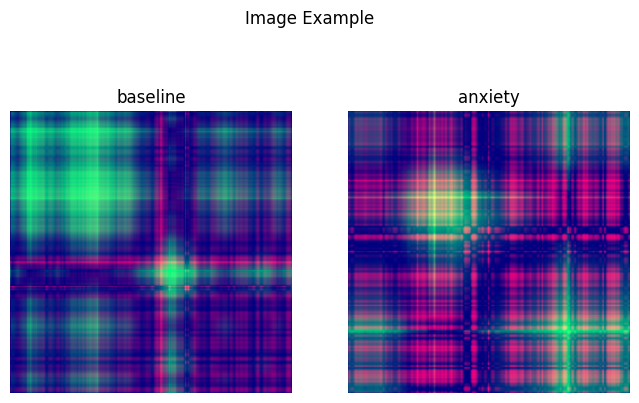

In [5]:
images = []
paths = []

fig,ax = plt.subplots(1,2,figsize = (8,5))
ax = ax.ravel()

for idx, i in enumerate(classes):
    img_base_path = "C:/Users/aless/Desktop/gaf_imgs/" + str(i) #link of the subfolders
    timages = os.listdir(img_base_path) #list of images inside each subfolders
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[idx]
    ax[idx].axis('off')
    ax[idx].imshow(image,cmap = 'gray')
    ax[idx].set_title(str(i))

plt.suptitle('Image Example')
plt.show()

In [3]:
data = datasets.ImageFolder('C:/Users/aless/Desktop/gaf_imgs/')
transform = transforms.Compose([transforms.RandomHorizontalFlip(1),
                                transforms.RandomVerticalFlip(1),
                                transforms.RandomRotation(30),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])
class loadData(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
          
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)
dataset = loadData(data, transform)
print(dataset[0][0].shape)

torch.Size([3, 250, 250])


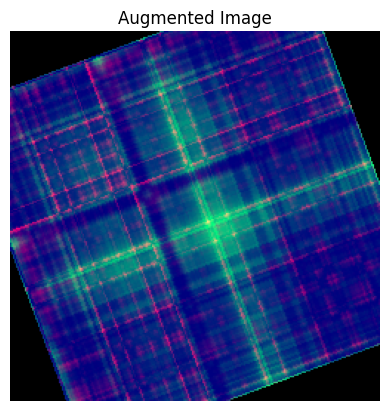

In [4]:
plt.imshow(dataset[3][0].permute(1, 2, 0))
plt.axis('off')
plt.title('Augmented Image')
plt.show()

## Network Architecture

In [5]:
class SeqCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2, stride=1, dilation=1, padding_mode='zeros'),  
        nn.BatchNorm2d(8), # Add Batch Normalization
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(16), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(32), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [9]:
dataset[0][0].shape

torch.Size([3, 250, 250])

In [10]:
net = SeqCNN()

img = dataset[0][0]
img = img.unsqueeze(0)

output = net(img)
print(output.shape)


out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

torch.Size([1, 32, 62, 62])
123008


In [11]:
class CNN(nn.Module):

 # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2, stride=1, dilation=1, padding_mode='zeros'),  
        nn.BatchNorm2d(8), # Add Batch Normalization
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(16), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(32), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(123008, 1012), #input and output neurons
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(1012, 2)  #input and output neurons
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)     # x has size [batch_size, num_filters, height, width] before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1)  # now x has size [batch_size, num_features]
    output = self.fc_layers(x) #  --> [B, 10]
    return output

In [12]:
model = CNN()
import torch
import torchsummary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

input_size = ( 3, 250, 250) 

# Summarize the model
summary = torchsummary.summary(model, input_size= input_size)

# Print the summary
print(summary)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       608
|    └─BatchNorm2d: 2-2                  16
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       1,168
|    └─BatchNorm2d: 2-5                  32
|    └─ReLU: 2-6                         --
|    └─MaxPool2d: 2-7                    --
|    └─Conv2d: 2-8                       4,640
|    └─BatchNorm2d: 2-9                  64
|    └─ReLU: 2-10                        --
|    └─MaxPool2d: 2-11                   --
├─Sequential: 1-2                        --
|    └─Linear: 2-12                      124,485,108
|    └─ReLU: 2-13                        --
|    └─Linear: 2-14                      2,026
Total params: 124,493,662
Trainable params: 124,493,662
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       608
|    └─Bat


(dot.exe:9144): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


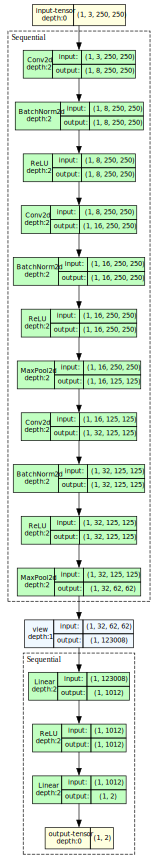

In [13]:
model_graph = draw_graph(model, input_size=(1,3,250,250), roll=True, expand_nested=True, directory='')
model_graph.visual_graph

In [14]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.0001, weight_decay=0.1)
# Define a loss 
criterion = nn.CrossEntropyLoss()

## Training

In [15]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset, SubsetRandomSampler, ConcatDataset

num_epochs=10
batch_size=1
k=15
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [16]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
      for images, labels in dataloader:

          images,labels = images.to(device),labels.to(device)
          output = model(images)
          loss=loss_fn(output,labels)
          valid_loss+=loss.item()*images.size(0)
          scores, predictions = torch.max(output.data,1)
          val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [17]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    model = CNN()
    model.to(device)

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)   

Fold 1
Epoch:1/10 AVG Training Loss:0.726 AVG Test Loss:0.634 AVG Training Acc 50.00 % AVG Test Acc 100.00 %
Epoch:2/10 AVG Training Loss:0.762 AVG Test Loss:0.590 AVG Training Acc 42.86 % AVG Test Acc 100.00 %
Epoch:3/10 AVG Training Loss:0.692 AVG Test Loss:0.471 AVG Training Acc 50.00 % AVG Test Acc 100.00 %
Epoch:4/10 AVG Training Loss:0.743 AVG Test Loss:0.409 AVG Training Acc 50.00 % AVG Test Acc 100.00 %
Epoch:5/10 AVG Training Loss:0.712 AVG Test Loss:0.388 AVG Training Acc 50.00 % AVG Test Acc 100.00 %
Epoch:6/10 AVG Training Loss:0.712 AVG Test Loss:0.368 AVG Training Acc 50.00 % AVG Test Acc 100.00 %
Epoch:7/10 AVG Training Loss:0.701 AVG Test Loss:0.328 AVG Training Acc 50.00 % AVG Test Acc 100.00 %
Epoch:8/10 AVG Training Loss:0.735 AVG Test Loss:0.397 AVG Training Acc 50.00 % AVG Test Acc 100.00 %
Epoch:9/10 AVG Training Loss:0.726 AVG Test Loss:0.409 AVG Training Acc 50.00 % AVG Test Acc 100.00 %
Epoch:10/10 AVG Training Loss:0.731 AVG Test Loss:0.402 AVG Training Acc 50

In [18]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_test_acc = np.mean(history['test_acc'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))  

Performance of 15 fold cross validation
Average Training Loss: 0.7050 	 Average Test Loss: 0.6633 	 Average Training Acc: 50.333 	 Average Test Acc: 55.333


## Interpretability

In [45]:
img = dataset[14][0]
label = dataset[14][1]

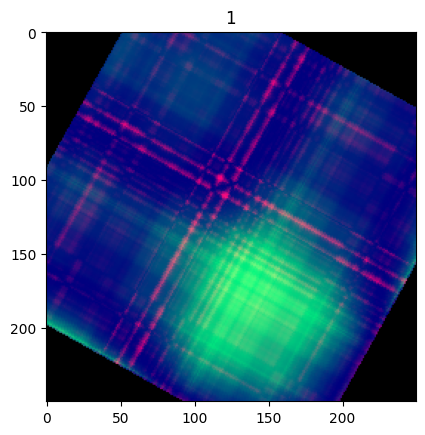

In [46]:
plt.imshow(img.permute(1, 2, 0))
plt.title(str(label))
plt.show()

In [47]:
input_img = img.unsqueeze(0).to(device)

In [48]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
print(pred_label_idx)

tensor(1)


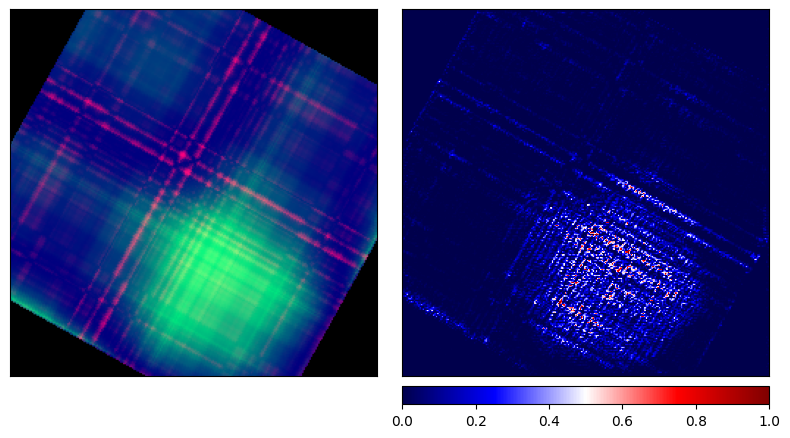

In [49]:
gg = GuidedGradCam(model, model.conv_layer[7])
gg_attr = gg.attribute(input_img, pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ['original_image', "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)